# Hybrid Model 01: Sjednocení modelů (Models integration)

In [1]:
# Instalace potřebných knihoven
#%pip install pandas
#%pip install numpy
#%pip install seaborn matplotlib

In [2]:
# Import potřebných knihoven
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

### Vstupní data

In [3]:
### Deterministická data

# Soubor je načten a přiřazen do proměnné ‚df_cycl‘
other_path = '../../data/02_DetermModel/model_data.csv'
df_cycl = pd.read_csv(other_path, header=0)
df_cycl

,x,y,z,dist,time
0,74,459,1284,4840,39.019
1,-90,4908,2217,4571,38.212
2,522,3074,26,2718,32.653
3,425,2247,2739,4318,37.453
4,516,3425,1590,3308,34.423
...,...,...,...,...,...
19995,3122,589,704,7604,47.311
19996,1693,319,1561,6726,44.677
19997,2078,-4,46,7198,46.093
19998,3151,317,2282,8632,50.395


### Generování časové trajektorie deterministické doby cyklu

In [4]:
# Zaokrouhlení hodnot, převod na int a vytvoření čísla cyklu z indexu
df_cycl['time'] = df_cycl['time'].round().astype(int)
df_cycl['dist'] = df_cycl['dist'].round().astype(int)
df_cycl['cycle'] = df_cycl.index + 1
df_cycl

,x,y,z,dist,time,cycle
0,74,459,1284,4840,39,1
1,-90,4908,2217,4571,38,2
2,522,3074,26,2718,33,3
3,425,2247,2739,4318,37,4
4,516,3425,1590,3308,34,5
...,...,...,...,...,...,...
19995,3122,589,704,7604,47,19996
19996,1693,319,1561,6726,45,19997
19997,2078,-4,46,7198,46,19998
19998,3151,317,2282,8632,50,19999


In [5]:
# Rozbalení řádků s vytvořením průběžného času
df_cycl_time = (
    df_cycl.loc[df_cycl.index.repeat(df_cycl['time']), ['cycle']]
      .assign(time=lambda x: range(1, len(x) + 1))
      .reset_index(drop=True)
      [['time', 'cycle']]
)

df_cycl_time

,time,cycle
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
...,...,...
841483,841484,20000
841484,841485,20000
841485,841486,20000
841486,841487,20000


### Generování časové trajektorie stochastických vlivu

In [6]:
### Stochastická data

# Soubor je načten a přiřazen do proměnné ‚df_state‘
other_path = '../../data/03_StochModel/simulation_MCMC_samples.csv'
df_state = pd.read_csv(other_path, header=0)
df_state

,time,state_index
0,0,7
1,1,7
2,2,7
3,3,8
4,4,8
...,...,...
999995,999995,6
999996,999996,6
999997,999997,6
999998,999998,7


In [7]:
# nalezení indexu prvního výskytu stavu S1
idx_start = df_state[df_state['state_index'] == 1].index[0]

# odstranění všech řádků před tímto indexem
df_state = df_state.loc[idx_start:].reset_index(drop=True)

df_state

,time,state_index
0,9,1
1,10,1
2,11,2
3,12,2
4,13,3
...,...,...
999986,999995,6
999987,999996,6
999988,999997,6
999989,999998,7


### Definice neprovozních stavů

In [8]:
# definice neprovozních stavů systému
downtime_states = [9, 10, 11, 12]

### Mapa zpoždění pro jednotlivé stavy

In [ ]:
# doba trvání neprovozních stavů [s]
state_delay_map = {
    9: 60,   # manuální kontrola a servis
    10: 70,  # výměna defektního materiálu
    11: 160, # oprava systému
    12: 20,  # otáčení zdicího prvků
}

### Výpočet stochastického zpoždění

In [10]:
# přiřazení zpoždění podle aktuálního stavu
df_state['stochastic_delay'] = df_state['state_index'].map(state_delay_map)

# provozní stavy mají nulové zpoždění
df_state['stochastic_delay'] = df_state['stochastic_delay'].fillna(0)
df_state['stochastic_delay'] = df_state['stochastic_delay'].round().astype(int)
df_state = df_state[df_state['stochastic_delay'] != 0]
df_state

,time,state_index,stochastic_delay
575,584,10,70
576,585,10,70
577,586,10,70
578,587,10,70
579,588,10,70
...,...,...,...
999652,999661,12,20
999653,999662,12,20
999654,999663,12,20
999655,999664,12,20


In [11]:
# začátek výskytu zpoždění
df_state = df_state[df_state['state_index'].ne(df_state['state_index'].shift())]
df_state

,time,state_index,stochastic_delay
575,584,10,70
958,967,12,20
3180,3189,10,70
3492,3501,12,20
5587,5596,9,60
...,...,...,...
996325,996334,10,70
997773,997782,12,20
999026,999035,10,70
999156,999165,9,60


### Sjednocení fyzikálního a stochastického modelu

In [12]:
# Přiřazení stochastic_delay ke každému cycle podle shodného času
df_delay_cycle = (
    df_cycl_time
    .merge(df_state[['time', 'stochastic_delay']], on='time', how='left')
    .dropna(subset=['stochastic_delay'])
    .drop_duplicates('cycle')
    [['cycle', 'stochastic_delay']]
)

df_cycl = df_cycl.merge(df_delay_cycle, on='cycle', how='left')

df_cycl

,x,y,z,dist,time,cycle,stochastic_delay
0,74,459,1284,4840,39,1,NaN
1,-90,4908,2217,4571,38,2,NaN
2,522,3074,26,2718,33,3,NaN
3,425,2247,2739,4318,37,4,NaN
4,516,3425,1590,3308,34,5,NaN
...,...,...,...,...,...,...,...
19995,3122,589,704,7604,47,19996,NaN
19996,1693,319,1561,6726,45,19997,NaN
19997,2078,-4,46,7198,46,19998,NaN
19998,3151,317,2282,8632,50,19999,NaN


In [13]:
# Nahrazení NaN ve stochastic_delay nulou a převod na int
df_cycl['stochastic_delay'] = df_cycl['stochastic_delay'].fillna(0).astype(int)
df_cycl

,x,y,z,dist,time,cycle,stochastic_delay
0,74,459,1284,4840,39,1,0
1,-90,4908,2217,4571,38,2,0
2,522,3074,26,2718,33,3,0
3,425,2247,2739,4318,37,4,0
4,516,3425,1590,3308,34,5,0
...,...,...,...,...,...,...,...
19995,3122,589,704,7604,47,19996,0
19996,1693,319,1561,6726,45,19997,0
19997,2078,-4,46,7198,46,19998,0
19998,3151,317,2282,8632,50,19999,0


In [14]:
# Výpočet nového total_time jako součet původního času a stochastic_delay
df_cycl['total_time'] = df_cycl['time'] + df_cycl['stochastic_delay']

# Výběr relevantních sloupců
df_cycl = df_cycl[['x','y','z','dist','time','stochastic_delay', 'total_time']]
df_cycl

,x,y,z,dist,time,stochastic_delay,total_time
0,74,459,1284,4840,39,0,39
1,-90,4908,2217,4571,38,0,38
2,522,3074,26,2718,33,0,33
3,425,2247,2739,4318,37,0,37
4,516,3425,1590,3308,34,0,34
...,...,...,...,...,...,...,...
19995,3122,589,704,7604,47,0,47
19996,1693,319,1561,6726,45,0,45
19997,2078,-4,46,7198,46,0,46
19998,3151,317,2282,8632,50,0,50


In [15]:
# Výběr řádků, kde je stochastic_delay větší než 0
df_cycl[df_cycl['stochastic_delay'] > 0]

,x,y,z,dist,time,stochastic_delay,total_time
16,28,-81,46,5225,40,70,110
26,591,316,254,5351,41,20,61
87,70,4919,886,4090,37,70,107
96,67,1977,360,3155,34,20,54
152,-99,367,143,4629,38,60,98
...,...,...,...,...,...,...,...
19882,2069,599,1336,6716,45,20,65
19885,4060,587,855,8568,50,70,120
19929,1487,420,1399,6341,44,20,64
19932,934,-16,1057,6095,43,160,203


In [16]:
# celková mimopracovní doba, sek
print(f'Celkový mimopracovní běh systému: {df_cycl["stochastic_delay"].sum()} sek')
print(f'Celkový běh systému: {df_cycl["total_time"].sum()} sek')

Celkový mimopracovní běh systému: 88240 sek
Celkový běh systému: 929728 sek


### Graf: Podíl zpoždění podle času

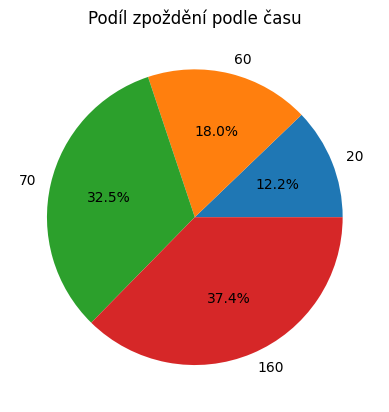

In [17]:
# výběr cyklů se zpožděním
df_delay_sum = (
    df_cycl[df_cycl['stochastic_delay'] > 0]
    .groupby('stochastic_delay')['stochastic_delay']
    .sum()
)

plt.figure()

plt.pie(
    df_delay_sum,
    labels=df_delay_sum.index,
    autopct='%1.1f%%'
)

plt.title("Podíl zpoždění podle času")
plt.show()

### Graf: Kumulativní stochastické zpoždění

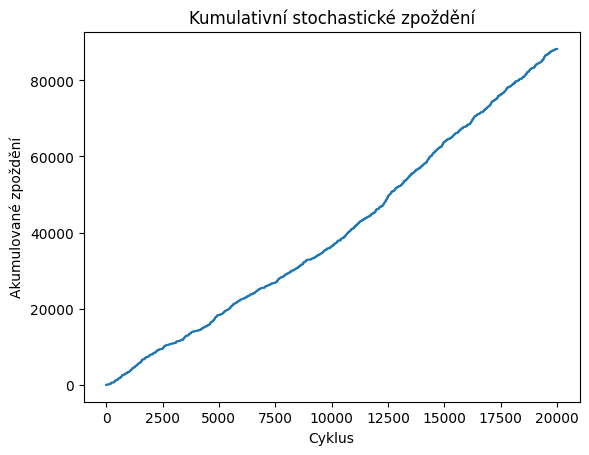

In [18]:
df_cycl = df_cycl.copy()
df_cycl.loc[:, 'cum_delay'] = df_cycl['stochastic_delay'].cumsum()

plt.figure()

plt.plot(df_cycl['cum_delay'])

plt.title("Kumulativní stochastické zpoždění")
plt.xlabel("Cyklus")
plt.ylabel("Akumulované zpoždění")
plt.show()

### Export datové sady do formátu CSV

In [19]:
df_cycl.to_csv('../../data/04_HybridModel/hybrid_model.csv', index=False)

### Autor / Organizace / Datum

Vjačeslav Usmanov, ČVUT v Praze, Fakulta stavební

###### Přehled změn


|  Datum (YYYY-MM-DD) |  Verze | Autor změny  |  Popis změny |
|---|---|---|---|
| 2026-01-27 | 1.1 | Vjačeslav Usmanov| added HM_01_Models_Integration.ipynb |
| 2026-02-16 | 1.2 | Vjačeslav Usmanov| changed HM_01_Models_Integration.ipynb |